This notebook is created during Vincent's Lab RETTL Project Summer 2022 by Tianze (Steven) Shou 

In this notebook, we are going to take `detector_results.csv` and aggregate the data by `studentID` to summarize each student's struggle, system misuse, gaming, and idleness status. We are also going to summarize teacher's help offered to each student, each student's help seeking pattern (raising hands) from `observation_events.tsv`. Eventually we are going to put them together to see if these variables pertain any correlation. 

In [1]:
# python setup 
import pandas as pd
import numpy as np
import seaborn as sns
import import_ipynb
from tutor_log_summary_stat import *

importing Jupyter notebook from tutor_log_summary_stat.ipynb


# 1. Data Aggregation 

We are going to aggregate all extracted data into `analyticsDF` for further analysis. 

In [2]:
# file loading 
detectorDF = pd.read_csv("output_files/detector_results.csv", index_col=False) 

obsEventsDF = pd.read_csv("output_files/event_master_file_D10_R500_RNG1000_sprint2_shou.csv", index_col=False)
obsEventsDF = obsEventsDF.loc[obsEventsDF["modality"] == "observation"]

# using rng=1000 here 
stopsDF = pd.read_csv("output_files/event_master_file_D10_R500_RNG1000_sprint2_shou.csv", index_col=False) 
stopsDF = stopsDF.loc[stopsDF["event"] == "Stopping"]
stopsDF.index = np.arange(len(stopsDF))

## 1.1 Extracting Hand-Raises and On-Task Teacher-Visits From Observation

In [3]:
def isValidStudID(studID) -> bool: 
    if not isinstance(studID, str): return False 
    return studID[:4] == "Stu_"

# extract number of teacher visits and number of hand raises by studentID, periodID, and dayID from observation events 
if __name__ == "__main__": 

    # structure of these mapping: (dayID, periodID, studID): number of 
    # teahcer-visit/hand-raises during the day/period for the given student 
    teacherVisitMapping = dict() 
    handRaisesMapping = dict() 

    for i in obsEventsDF.index: 

        event = obsEventsDF.loc[i, "event"] 
        isVisitEvent = (event == "Talking to student: ON-task" or 
                        event == "Talking to small group: ON-task") 
        isHandRaiseEvent = (event == "Raising hand")

        # ensure this row's "subject" value is string, not NaN
        if isinstance(obsEventsDF.loc[i, "subject"], str): 
            subjects = obsEventsDF.loc[i, "subject"].split(";")
        else: 
            subjects = []
        
        actor = obsEventsDF.loc[i, "actor"] 
        periodID, dayID = obsEventsDF.loc[i, "periodID"], obsEventsDF.loc[i, "dayID"]

        # valid visit event with valid student as subject, add 1 to count 
        for subject in subjects:
            if isVisitEvent and isValidStudID(subject): 
                teacherVisitMapping[(dayID, periodID, subject)] = teacherVisitMapping.get((dayID, periodID, subject), 0) + 1 

        # valid hand-raising event with valid student as actor, add 1 to count
        if isHandRaiseEvent and isValidStudID(actor): 
            handRaisesMapping[(dayID, periodID, actor)] = handRaisesMapping.get((dayID, periodID, actor), 0) + 1 

    # transform mappings into dataframes 
    dayID = [ key[0] for key in teacherVisitMapping ] 
    periodID = [ key[1] for key in teacherVisitMapping ] 
    studentID = [ key[2] for key in teacherVisitMapping ] 
    totalTeacherVisits = [ teacherVisitMapping[key] for key in teacherVisitMapping ] 
    teacherVisitDF = pd.DataFrame({"dayID": dayID, 
                                   "periodID": periodID, 
                                   "studentID": studentID, 
                                   "totalOnTaskTeacherVisits": totalTeacherVisits}) 

    # do the same to hand raises 
    dayID = [ key[0] for key in handRaisesMapping ] 
    periodID = [ key[1] for key in handRaisesMapping ] 
    studentID = [ key[2] for key in handRaisesMapping ] 
    totalHandRaises = [ handRaisesMapping[key] for key in handRaisesMapping ] 
    handRaisesDF = pd.DataFrame({"dayID": dayID, 
                                 "periodID": periodID, 
                                 "studentID": studentID, 
                                 "totalHandRaises": totalHandRaises}) 

    # outer join teahcer-vists and hand-raises dataframe 
    analyticsDF = pd.merge(teacherVisitDF, handRaisesDF, 
                           on=["dayID", "periodID", "studentID"], how="outer")

    
    
    # just met with Shamya, and should start with splitting by student, ignoring day and period 
    analyticsDF = analyticsDF.groupby(by=["studentID"]).sum()
    analyticsDF = analyticsDF.drop(["dayID", "periodID"], axis=1)

## 1.2 Extracting In-Range Stops from Position Events

In [4]:

def mapping2DF(mapping: dict, valueColumnName: str): 
    """
    Taking in mapping where (dayID, periodID, studentID) -> some_value, this function return a 
    pandas dataframe with each row corresponding to each key-value pair

    Args:
        mapping (dict): hash dictionary mapping with key-value pairs in the form: (dayID, periodID, studentID) -> some_value
        valueColumnName (str): column name for the value column 

    Returns:
        pandas.Dataframe: a pandas dataframe holding all entries in the mapping 
    """

    dayID = [key[0] for key in mapping]
    periodID = [key[1] for key in mapping] 
    studentID = [key[2] for key in mapping] 
    value = [ mapping[key] for key in mapping ] 

    DF = pd.DataFrame({"dayID": dayID, 
                       "periodID": periodID, 
                       "studentID": studentID, 
                       valueColumnName: value}) 

    return DF 

def oneKeyMappingToDF(mapping: dict, colName: str): 
    """
    Transform a dictionary mapping into a pandas dictionary. Mapping's keys must 
    be of length one, meaning that keys should not be tuples 
    """

    studentID = [ key for key in mapping ] 
    val = [ mapping[key] for key in mapping ] 

    return pd.DataFrame({"studentID": studentID, 
                         colName: val})

if __name__ == "__main__": 

    # structure of these mapping: studID: time length of 
    # stops during the day/period for the given student 
    stopsMapping = dict() 
    currStopStart = None # current stop starting time stamp
    for i in stopsDF.index: 

        if i == 0: currStopStart = stopsDF.loc[i, "timestamp"] 

        # this signals that indexing has jumped to the next stop
        elif stopsDF.loc[i, "content"] != stopsDF.loc[i-1, "content"]: 

            studentID = stopsDF.loc[i-1, "subject"] 
            dayID = stopsDF.loc[i-1, "dayID"] 
            periodID = stopsDF.loc[i-1, "periodID"] 
            currStopEnd = stopsDF.loc[i-1, "timestamp"] 

            if isValidStudID(studentID): # studentID must not be NaN 
                # add current stop length (currStopEnd - currStopStart) to mapping 
                currStopLength = currStopEnd - currStopStart
                stopsMapping[studentID] = stopsMapping.get(studentID, []) + [currStopLength]

            # update the starting time of current stop 
            currStopStart = stopsDF.loc[i, "timestamp"] 

        # this signals that indexing is still within the same stop 
        else: pass

    studentID = [ key for key in stopsMapping ]
    totalStopLength = [ sum(stopsMapping[key]) for key in stopsMapping ] 
    stopsLengthMean = [ np.mean(stopsMapping[key]) for key in stopsMapping ] 
    stopsLengthStd = [ np.std(stopsMapping[key]) for key in stopsMapping ] 
    stopsLengthMin = [ min(stopsMapping[key]) for key in stopsMapping ] 
    stopsLengthMax = [ max(stopsMapping[key]) for key in stopsMapping ] 
    
    studentStopDF = pd.DataFrame({"studentID": studentID, 
                                  "totalStopLength": totalStopLength, 
                                  "stopsLengthMean": stopsLengthMean, 
                                  "stopsLengthStd": stopsLengthStd, 
                                  "stopsLengthMin": stopsLengthMin, 
                                  "stopsLengthMax": stopsLengthMax}) 
    # merge with analyticsDF 
    analyticsDF = pd.merge(analyticsDF, studentStopDF, 
                           on=["studentID"], how="outer")



## 1.3 Extracting Off-Task Teach Visits from Observation 

In [5]:
if __name__ == "__main__": 

    StudID2OffTaskConvMapping = dict() 

    for i in obsEventsDF.index: 
        
        # filter out the off task conversations 
        if "off-task" in obsEventsDF.loc[i, "event"].lower(): 
            studentIDs = obsEventsDF.loc[i, "subject"].split(';') 

            # increment each student's number of off-task visit in the subject list
            for studentID in studentIDs: 
                if isValidStudID(studentID): 
                    StudID2OffTaskConvMapping[studentID] = StudID2OffTaskConvMapping.get(studentID, 0) + 1

    # transform mapping to dataframe and outer join with analyticsDF 
    offTaskConvDF = oneKeyMappingToDF(StudID2OffTaskConvMapping, "totalOffTaskTeacherVisits") 
    analyticsDF = pd.merge(offTaskConvDF, analyticsDF, on="studentID", how="outer")


## 1.4 Extracting Tutor Statistics 

Things to be extracted: overall performance for each student (# of correct attempts / (# of correct + # of incorrect + # of hints)), KC level performance, number of hints requested, number of problems finished, number of steps involved, time taken per step. 

In [6]:
# load tutor data, this function getAnnotatedTutorLogDF() is from tutor_log_summary_stat.ipynb
if __name__ == "__main__": 
    tutorLogDF = getAnnotatedTutorLogDF() 

<string>:15: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.


In [7]:
if __name__ == "__main__": 

    # all the unique student id's
    students = tutorLogDF["Anon Student Id"].unique().tolist() 

    # setup KC level performance column names 
    KCNames = pd.Series(['cancel-const', 'division-simple', 'divide',
                         'subtraction-const', 'combine-like-const', 'subtraction-var',
                         'combine-like-var', 'cancel-var', 'distribute-division',
                         'division-complex']) 
    KCPerformanceColNames = KCNames + "Performance" 
    KCPerformanceColNames = KCPerformanceColNames.tolist() 

    # setup tutor summary stat dataframe, index is by student ID 
    tutorSummaryDF = pd.DataFrame(columns=["overallPerformance", "hintRequested", 
                                           "problemsSolved", "totalSteps", 
                                           "timePerStep"] + KCPerformanceColNames, 
                                           index=students) 

    # extract individual student performance statistics 
    for studentID in tutorSummaryDF.index: # since this dataframe is indexed by studentID 
        # overall performance 
        tutorSummaryDF.loc[studentID, "overallPerformance"] = getStudentPerformanceSummary(tutorLogDF, students=[studentID]) 
        # number of hints 
        tutorSummaryDF.loc[studentID, "hintRequested"] = getNumOfHints(tutorLogDF, students=[studentID]) 
        # number of problems solved 
        tutorSummaryDF.loc[studentID, "problemsSolved"] = getNumOfProblemsSolved(tutorLogDF, students=[studentID]) 
        # number of steps 
        tutorSummaryDF.loc[studentID, "totalSteps"] = getNumOfSteps(tutorLogDF, students=[studentID]) 
        # avearge time taken per step 
        tutorSummaryDF.loc[studentID, "timePerStep"] = getTimePerStep(tutorLogDF, students=[studentID]) 
        # get KC level performance for each student 
        studentKCPerformanceMapping = getKCLevelPerformance(tutorLogDF, students=[studentID], suffix="Performance") 
        for colName in studentKCPerformanceMapping: 
            tutorSummaryDF.loc[studentID, colName] = studentKCPerformanceMapping[colName] 




In [9]:
# outer join tutor summary data for each student with analyticsDF 
if __name__ == "__main__": 
    tutorSummaryDF["studentID"] = tutorSummaryDF.index
    analyticsDF = pd.merge(analyticsDF, tutorSummaryDF, on="studentID", how="outer")

# 2. Filling missing values

In [10]:
# columns that can be filled with zero's
for col in ["totalTeacherVisits", "totalHandRaises", "totalStopLength"]: 
    analyticsDF[col] = analyticsDF[col].fillna(0)

# 3. Visualization 

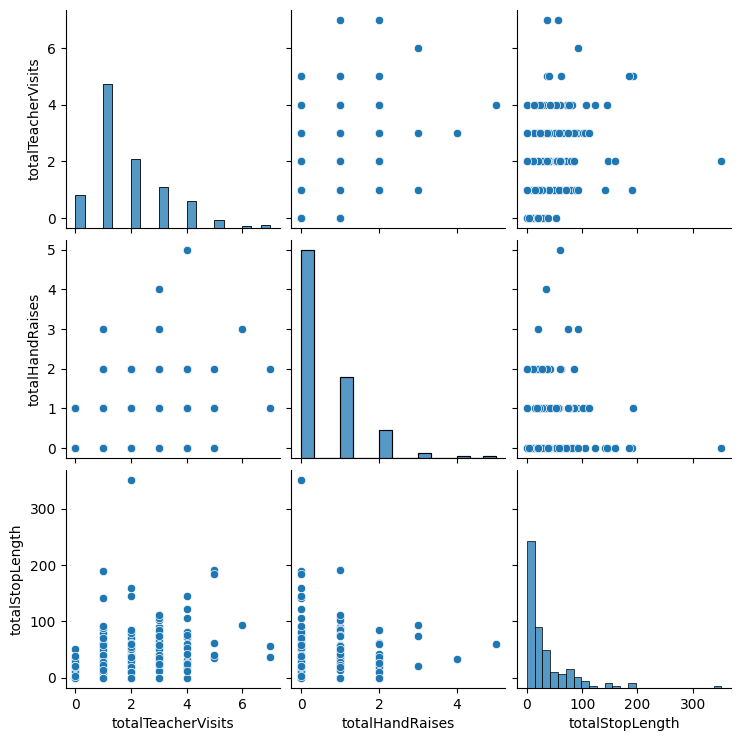

In [11]:
visualDF = analyticsDF.drop(columns=["dayID", "periodID", "studentID"])
sns.pairplot(visualDF)

In [10]:
# test chunk 



ValueError: Unable to parse string "." at position 566